# Statistical Tests

This notebook builds on the KPI breakdown by performing statistical tests to determine whether key performance differences between Market 1 and other markets are statistically significant.
The focus is on validating whether observed patterns (e.g., higher busy ratio, certain cuisine delays) are meaningful and not due to random variation.

# Import Libraries

In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, mannwhitneyu, spearmanr, ttest_ind, ttest_rel
from statsmodels.stats.proportion import proportions_ztest

import statsmodels.api as sm
import statsmodels.formula.api as smf




In [11]:
df = pd.read_csv("/Users/ridhampatel/Documents/DS/Projects/Doordash/kpi_dataset.csv")

# Are the On-time delivery rates are the same across all markets?

Hypotheses:

- Null (H₀): On-time delivery rates are the same across all markets.

- Alternative (H₁): At least one market’s on-time delivery rate differs from the others.

We use a Chi-square test of independence to see if the proportion of on-time vs late deliveries is independent of market.

In [12]:
contingency = pd.crosstab(df['market_id'], df['is_on_time'])

# Chi-square test
chi_stat, p_val, dof, expected = chi2_contingency(contingency)

print(f"Chi-square statistic = {chi_stat:.4f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p_val:.4g}")

if p_val < 0.05:
    print("Significant differences in on-time performance across markets.")
else:
    print("No significant differences between markets.")

Chi-square statistic = 359.6883
Degrees of freedom = 5
P-value = 1.436e-75
Significant differences in on-time performance across markets.


The chi-square test confirms that on-time performance varies significantly between markets (p < 0.001).

# Are Market 1 and Market 5 Performance Rates Different?

In [13]:

market1 = df[df['market_id'] == 1]
market5 = df[df['market_id'] == 5]

count = [market1['is_on_time'].sum(), market5['is_on_time'].sum()]
nobs = [len(market1), len(market5)]

# z-test for proportions
stat, p_val = proportions_ztest(count, nobs)

print(f"Z-statistic = {stat:.4f}")
print(f"P-value = {p_val:.4g}")

if p_val < 0.05:
    print("Market 1 and Market 5 differ significantly in on-time performance.")
else:
    print("No significant difference between Market 1 and Market 5.")

# Effect size
prop_diff = count[0]/nobs[0] - count[1]/nobs[1]
print(f"Difference in proportions = {prop_diff:.2%}")


Z-statistic = -15.4972
P-value = 3.623e-54
Market 1 and Market 5 differ significantly in on-time performance.
Difference in proportions = -5.68%


The two-proportion z-test shows that Market 1’s on-time rate is 5.68 percentage points lower than Market 5’s, and this difference is statistically significant (p < 0.001).

This supports prioritizing Market 1 for root cause analysis.

# Does the worst market have more bad cuisines?

In [14]:
cuisine_perf = (
    df.groupby("cuisine_grouped")["is_on_time"]
    .mean()
    .sort_values()
)
worst_5_cuisines = cuisine_perf.index[:5].tolist()
print(worst_5_cuisines)


['brazilian', 'nepalese', 'steak', 'cajun', 'sushi']


In [15]:
df["is_bad_cuisine"] = df["cuisine_grouped"].isin(worst_5_cuisines).astype(int)


Null hypothesis (H₀):
There is no association between market (1 vs 5) and the proportion of bad cuisines. 

Alternative hypothesis (H₁):
There is an association between market and the proportion of bad cuisines. The distribution of bad and not bad cuisines differs between Market 1 and Market 5.

In [16]:

contingency = pd.crosstab(df["market_id"], df["is_bad_cuisine"]).loc[[1,5]]
print(contingency)

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-square: {chi2:.4f}")
print(f"P-value: {p:.4g}")


is_bad_cuisine      0    1
market_id                 
1.0             36926  909
5.0             17377  530
Chi-square: 14.7842
P-value: 0.0001205


- The very low p-value (< 0.05) indicates a statistically significant difference in the distribution of bad cuisines between Market 1 and Market 5. 

- Market 1 has a higher count of bad cuisines compared to Market 5, suggesting the worst market indeed has more bad cuisines.

# Are Delivery Times for the Same Cuisines Slower in Market 1 Than in Market 5?

In [17]:
counts_m1 = df[df["market_id"] == 1]["cuisine_grouped"].value_counts()
counts_m5 = df[df["market_id"] == 5]["cuisine_grouped"].value_counts()

# Only keep cuisines that have >=200 orders in both markets
common_cuisines = counts_m1[counts_m1 >= 200].index.intersection(counts_m5[counts_m5 >= 200].index)

filtered_df = df[(df["market_id"].isin([1, 5])) & (df["cuisine_grouped"].isin(common_cuisines))]


In [18]:
common_cuisines

Index(['american', 'pizza', 'japanese', 'mexican', 'burger', 'fast', 'italian',
       'sandwich', 'chinese', 'breakfast', 'mediterranean', 'dessert', 'thai',
       'other', 'salad', 'cafe', 'vietnamese', 'indian', 'unknown', 'sushi',
       'greek', 'asian', 'korean'],
      dtype='object', name='cuisine_grouped')

In [19]:
lateness_by_market = (
    filtered_df
    .groupby(["market_id", "cuisine_grouped"])["is_late"]
    .mean()
    .unstack(level=0)  # Columns: market_id (1 and 5), Rows: cuisines
    .rename(columns={1: "Market 1", 5: "Market 5"})
)

lateness_by_market["Diff (M1 - M5)"] = lateness_by_market["Market 1"] - lateness_by_market["Market 5"]


Hypotheses:

H₀ (null): For the same cuisines, the mean lateness in Market 1 is equal to the mean lateness in Market 5.

H₁ (one-tailed): For the same cuisines, the mean lateness in Market 1 is greater than the mean lateness in Market 5.

In [20]:

valid_lateness = lateness_by_market.dropna()

# Paired t-test
stat, p_value = ttest_rel(valid_lateness["Market 1"], valid_lateness["Market 5"])

print(f"Paired t-test p-value: {p_value:f}")

Paired t-test p-value: 0.000005


In [21]:
df['is_late_int'] = df['is_late'].astype(int)

Insight:

Paired t-test (same cuisines) → p = 0.000012

Market 1 is consistently slower than Market 5 even for the same cuisines, pointing to market-driven delays (e.g., driver supply, traffic, batching) rather than cuisine type.

# Impact of Hour of Day on Lateness Rates


In [22]:
hourly_lateness = (
    df[df["market_id"].isin([1, 5])]
    .groupby(["market_id", "hour_of_day"])["is_late"]
    .agg(late_rate=lambda x: x.mean(), total_orders="count")
    .reset_index()
)


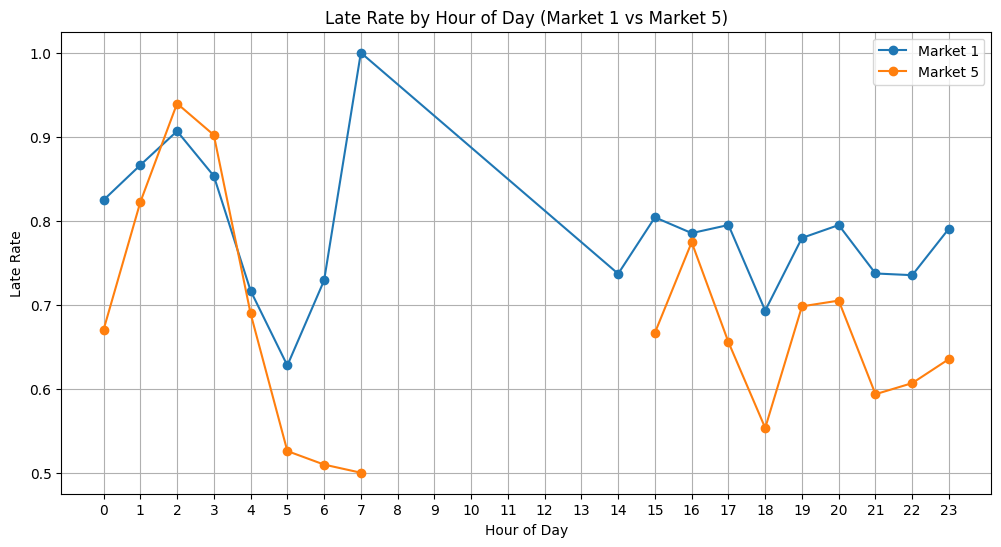

In [23]:
import matplotlib.pyplot as plt

pivot = hourly_lateness.pivot(index="hour_of_day", columns="market_id", values="late_rate")

plt.figure(figsize=(12, 6))
plt.plot(pivot.index, pivot[1], label="Market 1", marker='o')
plt.plot(pivot.index, pivot[5], label="Market 5", marker='o')
plt.title("Late Rate by Hour of Day (Market 1 vs Market 5)")
plt.xlabel("Hour of Day")
plt.ylabel("Late Rate")
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()


In [24]:
df['is_late_int'] = df['is_late'].astype(int)
df["market_1"] = (df["market_id"] == 1).astype(int)


- We define problematic hours as the time slots with the lowest on-time delivery rates to focus analysis on periods where lateness is already worst.

- This helps reveal whether Market 1’s poor performance is driven by these bad hours or persists even outside them, pointing to deeper structural issues.

In [25]:
worst_hours = [2, 3, 1, 15, 19, 16, 20]

df["is_problem_hour"] = df["hour_of_day"].isin(worst_hours).astype(int)

import statsmodels.formula.api as smf
model = smf.logit("is_late_int ~ market_1 * is_problem_hour", data=df).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.499584
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_late_int   No. Observations:               180240
Model:                          Logit   Df Residuals:                   180236
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Aug 2025   Pseudo R-squ.:                 0.04435
Time:                        12:16:48   Log-Likelihood:                -90045.
converged:                       True   LL-Null:                       -94224.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.6155      0.009     67.292      0.000       0.598

Key Findings

1. Market 1 effect (0.4443, p<0.001)

   In non-problem hours, Market 1 has higher lateness odds than Market 5.
   
   → Confirms there’s a structural performance issue not tied to bad hours alone.

2. Problem hours effect (1.1124, p<0.001)

   In Market 5, lateness odds are much worse during problem hours vs. other hours.
   
   → Problem hours are genuinely tough regardless of market.

3. Interaction (–0.3979, p<0.001)

   Surprisingly, Market 1’s lateness increases less during problem hours compared to Market 5.
   
   → Suggests Market 1 is already bad all the time, so the relative jump during problem hours is smaller.

# Are Market 1’s Worst Hours Driven by Higher Order Volumes?

In [26]:
markets = [1, 5]
df_markets = df[df['market_id'].isin(markets)]

volume_by_hour = (
    df_markets
    .groupby(['market_id', 'hour_of_day'])
    .size()
    .reset_index(name='order_volume')
)

volume_pivot = volume_by_hour.pivot(
    index='hour_of_day',
    columns='market_id',
    values='order_volume'
).fillna(0)


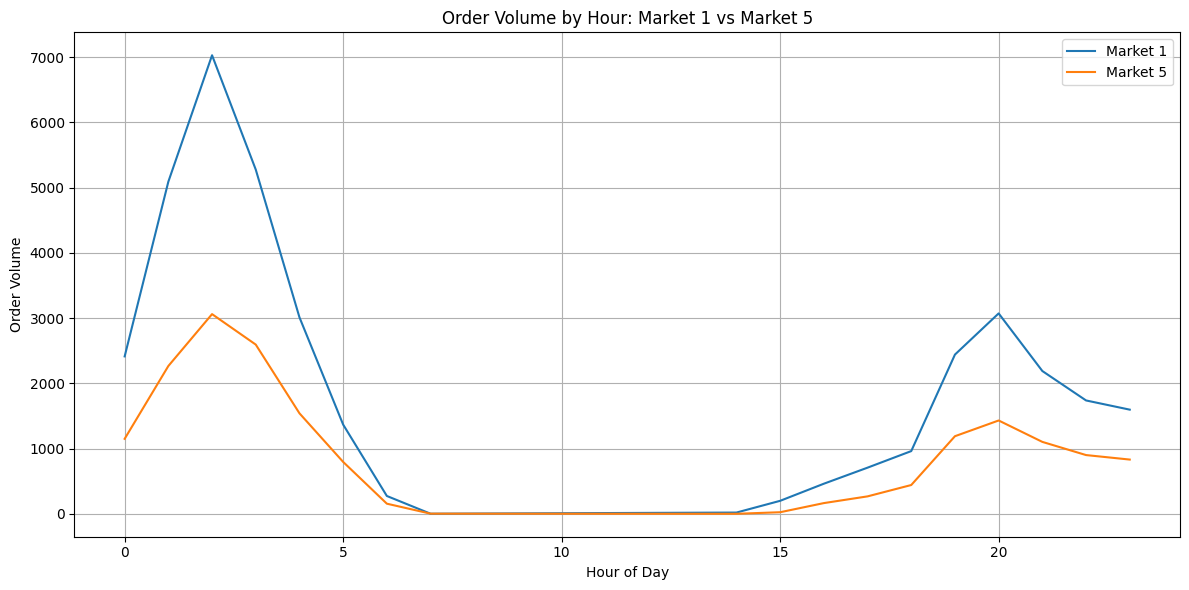

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(volume_pivot.index, volume_pivot[1], label='Market 1')
plt.plot(volume_pivot.index, volume_pivot[5], label='Market 5')

plt.xlabel('Hour of Day')
plt.ylabel('Order Volume')
plt.title('Order Volume by Hour: Market 1 vs Market 5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The chart shows that **Market 1 consistently handles higher order volumes** compared to Market 5, with especially sharp peaks in the early morning (around 2–3 AM) and evening hours (around 8–9 PM). 

These spikes indicate periods of high operational load, which could put pressure on driver supply and lead to delivery delays.


In [28]:
problematic_hours = [2, 3, 1, 15, 19, 16, 20]

df_problematic = df[(df['hour_of_day'].isin(problematic_hours)) & 
                    (df['market_id'].isin([1, 5]))]

orders_by_market = df_problematic.groupby('market_id').size().reset_index(name='num_orders')
orders_by_market


,market_id,num_orders
0,1.0,23563
1,5.0,10725


Null Hypothesis (H₀): The distribution of orders in Market 1 is less than or equal to the distribution in Market 5 during problematic hours.

Alternative Hypothesis (H₁): The distribution of orders in Market 1 is greater than the distribution in Market 5.



In [29]:
# Count orders per hour for each market
orders_per_hour = df_problematic.groupby(['market_id', 'hour_of_day']).size().reset_index(name='num_orders')

# Separate for the two markets
market1_counts = orders_per_hour[orders_per_hour['market_id']==1]['num_orders']
market5_counts = orders_per_hour[orders_per_hour['market_id']==5]['num_orders']
from scipy.stats import mannwhitneyu

# Test if Market 1 > Market 5
stat, p = mannwhitneyu(market1_counts, market5_counts, alternative='greater')
print(f"Mann-Whitney U statistic: {stat}, p-value: {p}")


Mann-Whitney U statistic: 37.0, p-value: 0.06410256410256411


Conclusion
- p > 0.05 → Not statistically significant at the 5% level.

- While the total number of orders is higher in Market 1, the per-hour distribution does not show a statistically significant difference from Market 5.

- Therefore, the worse performance of Market 1 cannot be explained by higher order volume during these problematic hours.

# Comparison of Order Size During Problematic Hours: Market 1 vs Market 5


Let's start with whether order size (number of items) is associated with lateness

Hypotheses:

Null Hypothesis (H₀):
There is no association or larger orders are not more likely to be late.

Alternative Hypothesis (H₁):
Larger orders are more likely to be late (negative correlation with is_on_time).


In [30]:

for market in [1, 5]:
    df_market = df_problematic[df_problematic['market_id']==market]
    corr, p_value = spearmanr(df_market['total_items'], df_market['is_on_time'])
    print(f"Market {market}: Spearman correlation = {corr:.3f}, p-value = {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"  Statistically significant association for Market {market}.")
        if corr < 0:
            print(f"  Larger orders are associated with more lateness in Market {market}.")
        else:
            print(f"  Larger orders are associated with being on-time in Market {market}.")
    else:
        print(f"  No statistically significant association found for Market {market}.")


Market 1: Spearman correlation = -0.103, p-value = 0.0000
  Statistically significant association for Market 1.
  Larger orders are associated with more lateness in Market 1.
Market 5: Spearman correlation = -0.129, p-value = 0.0000
  Statistically significant association for Market 5.
  Larger orders are associated with more lateness in Market 5.


Now, we know order size is significantly associated with lateness in both markets, the next step is to see whether Market 1 actually has larger orders than Market 5

In [31]:
df['volume_bin'] = pd.qcut(df['total_items'], q=3, labels=['Low', 'Med', 'High'])

df_markets = df[df.market_id.isin([1,5])]
df_markets.groupby(['market_id', 'volume_bin'])['is_late'].mean().unstack()


/var/folders/w6/6zbxrfhs3673cn004nn1v62h0000gn/T/ipykernel_1810/106399677.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_markets.groupby(['market_id', 'volume_bin'])['is_late'].mean().unstack()


volume_bin,Low,Med,High
market_id,,,
1.0,0.77500,0.822309,0.862334
5.0,0.70618,0.763045,0.836035


<Axes: xlabel='volume_bin', ylabel='is_on_time'>

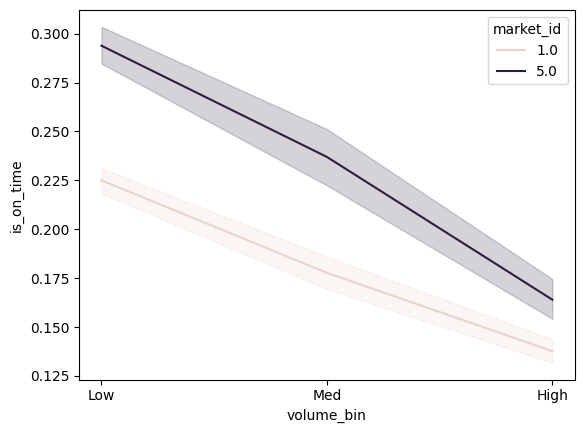

In [49]:
import seaborn as sns
sns.lineplot(data=df_markets, x='volume_bin', y='is_on_time', hue='market_id')


- Market 1 is the worse-performing market in terms of on-time delivery.

- Higher order volumes exacerbate lateness for both markets, but Market 1 struggles more overall.

Null hypothesis (H₀): Market 1 and Market 5 have the same lateness rate within this bin. Any observed difference is due to random chance.

Alternative hypothesis (H₁): Market 1 has a higher lateness rate than Market 5 within this bin.

In [54]:
from scipy.stats import chi2_contingency

from statsmodels.stats.proportion import proportions_ztest

df_bin = df[df['volume_bin'] == 'Low']
# Example for one bin
late_market1 = df_bin[(df_bin['market_id']==1)]['is_late'].sum()
n_market1 = df_bin[df_bin['market_id']==1].shape[0]

late_market5 = df_bin[(df_bin['market_id']==5)]['is_late'].sum()
n_market5 = df_bin[df_bin['market_id']==5].shape[0]

count = [late_market1, late_market5]
nobs = [n_market1, n_market5]

stat, pval = proportions_ztest(count, nobs)
print("Low")
print(f"Z-statistic: {stat}, p-value: {pval}")
print('\n')



df_bin = df[df['volume_bin'] == 'Med']
# Example for one bin
late_market1 = df_bin[(df_bin['market_id']==1)]['is_late'].sum()
n_market1 = df_bin[df_bin['market_id']==1].shape[0]

late_market5 = df_bin[(df_bin['market_id']==5)]['is_late'].sum()
n_market5 = df_bin[df_bin['market_id']==5].shape[0]

count = [late_market1, late_market5]
nobs = [n_market1, n_market5]

stat, pval = proportions_ztest(count, nobs)
print("Med")
print(f"Z-statistic: {stat}, p-value: {pval}")
print('\n')




df_bin = df[df['volume_bin'] == 'High']
# Example for one bin
late_market1 = df_bin[(df_bin['market_id']==1)]['is_late'].sum()
n_market1 = df_bin[df_bin['market_id']==1].shape[0]

late_market5 = df_bin[(df_bin['market_id']==5)]['is_late'].sum()
n_market5 = df_bin[df_bin['market_id']==5].shape[0]

count = [late_market1, late_market5]
nobs = [n_market1, n_market5]

stat, pval = proportions_ztest(count, nobs)
print("High")
print(f"Z-statistic: {stat}, p-value: {pval}")
print('\n')




Low
Z-statistic: 12.400593748652506, p-value: 2.593943615804276e-35


Med
Z-statistic: 7.284019530589962, p-value: 3.240180748321783e-13


High
Z-statistic: 4.5365952078821765, p-value: 5.71696867764065e-06




- In every bin, Market 1 has a significantly higher proportion of late deliveries than Market 5.

- This confirms that order size alone does not explain Market 1’s lateness — something else is amplifying delays.

# Busy_ratio

Null hypothesis (H₀): Busy ratio has no effect on the probability of lateness in this market.

Alternative hypothesis (H₁): A higher busy ratio increases the probability of lateness in this market.

In [34]:
import numpy as np


# Filter Market 1
df_m1 = df[df['market_id'] == 1].copy()
df_m1 = df_m1[np.isfinite(df_m1['busy_ratio'])]

model_m1 = smf.logit("is_late_int ~ busy_ratio", data=df_m1).fit()
print(model_m1.summary())

# Filter Market 5
df_m5 = df[df['market_id'] == 5].copy()
df_m5 = df_m5[np.isfinite(df_m5['busy_ratio'])]

model_m5 = smf.logit("is_late_int ~ busy_ratio", data=df_m5).fit()
print(model_m5.summary())


Optimization terminated successfully.
         Current function value: 0.481181
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_late_int   No. Observations:                35640
Model:                          Logit   Df Residuals:                    35638
Method:                           MLE   Df Model:                            1
Date:                Fri, 15 Aug 2025   Pseudo R-squ.:                 0.01671
Time:                        12:16:49   Log-Likelihood:                -17149.
converged:                       True   LL-Null:                       -17441.
Covariance Type:            nonrobust   LLR p-value:                9.346e-129
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0684      0.059      1.160      0.246      -0.047       0.184
busy_ratio     1.4515      0.

- Market 1 is highly sensitive to driver busyness.

    OR ~4.3 → lateness skyrockets if dashers are busy.

-  Market 5 is less sensitive.

    OR ~1.7 → busy dashers still increase lateness, but effect is smaller.

# Order_to_dasher Ratio

Hypotheses:

- Null hypothesis (H0): The mean order-to-dasher ratio is the same in both markets.

- Alternative hypothesis (Ha): The mean order-to-dasher ratio is different between the two markets.

In [35]:

market1_ratio = df[df['market_id'] == 1]['order_to_dasher_ratio']
market5_ratio = df[df['market_id'] == 5]['order_to_dasher_ratio']

market1_ratio_clean = market1_ratio[np.isfinite(market1_ratio)]
market5_ratio_clean = market5_ratio[np.isfinite(market5_ratio)]

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(market1_ratio_clean, market5_ratio_clean, equal_var=False)
print(t_stat, p_value)


42.650601007026424 0.0


- There is strong statistical evidence that the mean order-to-dasher ratio in Market 1 is significantly higher than in Market 5.

- This supports the operational observation that dashers in Market 1 are overloaded, contributing to higher lateness.

Hypotheses

1. Effect of order-to-dasher ratio (baseline: Market 5)

- H0: The order-to-dasher ratio has no effect on lateness in Market 5 (β_order_to_dasher_ratio = 0).

- Ha: The order-to-dasher ratio affects lateness in Market 5 (β_order_to_dasher_ratio ≠ 0).

2. Effect of Market 1 indicator (baseline: ratio = 0)

- H0: Baseline lateness odds are the same in Market 1 and Market 5 (β_is_market_1 = 0).

- Ha: Baseline lateness odds differ between Market 1 and Market 5 (β_is_market_1 ≠ 0).

3. Interaction term

- H0: The effect of order-to-dasher ratio is the same in Market 1 and Market 5 (β_ratio:is_market_1 = 0).

- Ha: The effect of order-to-dasher ratio differs between Market 1 and Market 5 (β_ratio:is_market_1 ≠ 0).

In [36]:
df_1_5 = df[df['market_id'].isin([1, 5])].copy()

df_1_5['is_market_1'] = (df_1_5['market_id'] == 1).astype(int)


In [37]:

df_1_5_clean = df_1_5[np.isfinite(df_1_5['order_to_dasher_ratio'])].copy()


formula = 'is_late_int ~ order_to_dasher_ratio + is_market_1 + order_to_dasher_ratio:is_market_1'
model = smf.logit(formula=formula, data=df_1_5_clean).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.476031
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_late_int   No. Observations:                53515
Model:                          Logit   Df Residuals:                    53511
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Aug 2025   Pseudo R-squ.:                 0.07289
Time:                        12:16:50   Log-Likelihood:                -25475.
converged:                       True   LL-Null:                       -27478.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.8438      0.051    -16

- Baseline lateness (is_market_1) = 0.639 → Market 1 has higher lateness even when order-to-dasher ratio = 0.

- Slope for ratio in Market 1 = 2.048 − 0.604 ≈ 1.444 → lateness still increases with ratio, but less steeply than in Market 5.

- Slope for ratio in Market 5 = 2.048 → lateness is more sensitive to changes in ratio.

# Exporting the dataset

In [38]:
df.to_csv("stattest_dataset.csv", index=False)
